Training with hidden_layer_sizes=(64,), learning_rate=0.0001
Final Loss: 0.0010, Validation Accuracy: 0.9682, Run Time: 97.84s


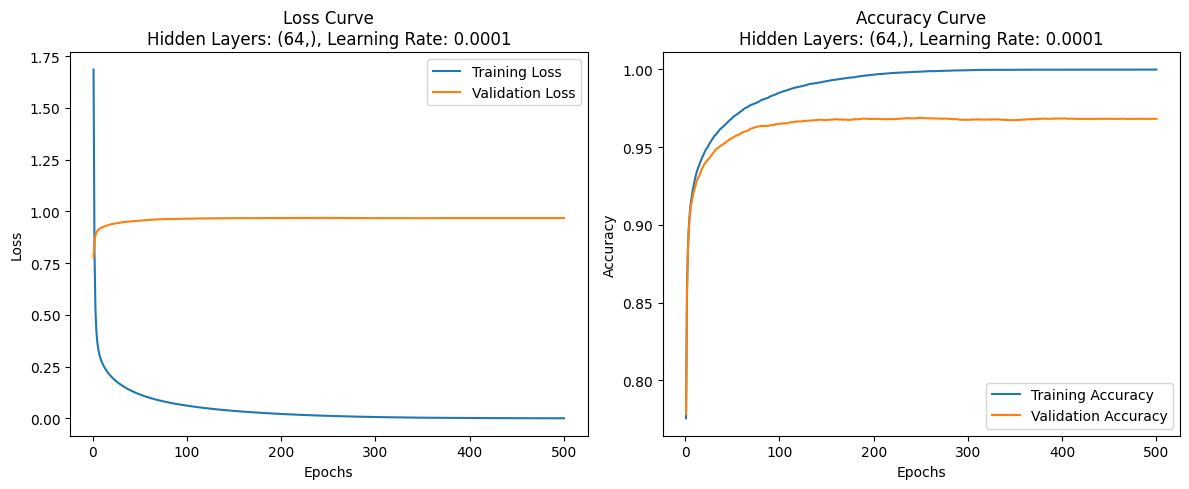

Training with hidden_layer_sizes=(64,), learning_rate=0.001


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:698: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")


KeyboardInterrupt: 

In [3]:
#author: mmj
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score
from file_utils import get_dataset
from sklearn.model_selection import train_test_split
import numpy as np
import time
import pandas as pd
import os
import matplotlib.pyplot as plt
import warnings
from sklearn.exceptions import ConvergenceWarning

# Function to log experiment results
def log_experiment(results, hidden_layer_sizes, learning_rate, val_accuracy, final_loss, run_time):
    results.append({
        'hidden_layer_sizes': hidden_layer_sizes,
        'learning_rate': learning_rate,
        'validation_accuracy': val_accuracy,
        'final_loss': final_loss,
        'run_time': run_time
    })
    return results


# Function to plot loss and accuracy curves
def plot_loss_accuracy(train_loss, val_loss, train_accuracy, val_accuracy, hidden_layer_sizes, learning_rate):
    epochs = range(1, len(train_loss) + 1)

    plt.figure(figsize=(12, 5))

    # Plot loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_loss, label='Training Loss')
    plt.plot(epochs, val_loss, label='Validation Loss')
    plt.title(f'Loss Curve\nHidden Layers: {hidden_layer_sizes}, Learning Rate: {learning_rate}')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_accuracy, label='Training Accuracy')
    plt.plot(epochs, val_accuracy, label='Validation Accuracy')
    plt.title(f'Accuracy Curve\nHidden Layers: {hidden_layer_sizes}, Learning Rate: {learning_rate}')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Hyperparameter tuning function
def hyperparameter_tuning(X_train, y_train, X_val, y_val):
    warnings.filterwarnings("ignore", category=ConvergenceWarning)
    hidden_layer_sizes_options = [
        (64,),  # Single layer
        (128,),  # Single layer
        (256,),  # Single layer
        (128, 64),  # Two layers
        (256, 128),  # Two layers
        (256, 128, 64)  # Three layers
    ]
    learning_rates = [0.0001, 0.001, 0.01, 0.1]

    best_accuracy = 0
    best_params = {}
    results = []  # To store all experiment results

    for hidden_layer_sizes in hidden_layer_sizes_options:
        for lr in learning_rates:
            print(f'Training with hidden_layer_sizes={hidden_layer_sizes}, learning_rate={lr}')
            start_time = time.time()  # Record start time

            # Initialize lists to store loss and accuracy for each epoch
            train_losses = []
            val_losses = []
            train_accuracies = []
            val_accuracies = []

            # Initialize the model
            model = MLPClassifier(
                hidden_layer_sizes=hidden_layer_sizes,
                learning_rate_init=lr,
                max_iter=1,  # Set max_iter=1 to manually control epochs
                warm_start=True,  # Enable incremental training
                random_state=42
            )

            # Train the model epoch by epoch
            for epoch in range(500):  # Train for 500 epochs
                model.fit(X_train, y_train)

                # Record training loss and accuracy
                train_losses.append(model.loss_)
                train_accuracies.append(model.score(X_train, y_train))

                # Record validation loss and accuracy
                val_loss = model.score(X_val, y_val)
                val_losses.append(val_loss)
                val_accuracies.append(val_loss)

            # Get final loss and accuracy
            final_loss = model.loss_
            val_accuracy = model.score(X_val, y_val)
            run_time = time.time() - start_time  # Calculate run time

            # Log experiment results
            results = log_experiment(results, hidden_layer_sizes, lr, val_accuracy, final_loss, run_time)

            print(f'Final Loss: {final_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}, Run Time: {run_time:.2f}s')

            # Plot loss and accuracy curves
            plot_loss_accuracy(train_losses, val_losses, train_accuracies, val_accuracies, hidden_layer_sizes, lr)

            if val_accuracy > best_accuracy:
                best_accuracy = val_accuracy
                best_params = {'hidden_layer_sizes': hidden_layer_sizes, 'learning_rate': lr}

    # Convert results to DataFrame
    results_df = pd.DataFrame(results)
    return results_df, best_params, best_accuracy


# Main function
if __name__ == "__main__":
    parent_path = './MNIST-full'  # Dataset root directory
    train_tsv_path = os.path.join(parent_path, 'gt-train.tsv')
    X, y = get_dataset(parent_path, file_path=train_tsv_path, num_samples=None)

    # split train and test
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=42)

    # Perform hyperparameter tuning
    results_df, best_params, best_accuracy = hyperparameter_tuning(X_train, y_train, X_val, y_val)

    # Train the final model with the best parameters

    # Get test data
    test_tsv_path = os.path.join(parent_path, 'gt-test.tsv')
    X_test, y_test = get_dataset(parent_path, file_path=test_tsv_path, num_samples=None)

    final_model = MLPClassifier(
        hidden_layer_sizes=best_params['hidden_layer_sizes'],
        learning_rate_init=best_params['learning_rate'],
        max_iter=1000,  # Increase iterations
        random_state=42
    )
    final_model.fit(X_test, y_test)

    # Get final loss and test accuracy
    final_loss = final_model.loss_
    test_accuracy = final_model.score(X_test, y_test)
    print(f'Final Loss: {final_loss:.4f}, Test Accuracy: {test_accuracy:.4f}')

    # Generate report.md
    with open('./resource/report.md', 'w') as f:
        # Write experiment results table
        f.write("## Experiment Results\n")
        f.write(results_df.to_markdown(index=False) + "\n\n")

        # Write best parameters and performance
        f.write("## Best Parameters and Performance\n")
        f.write(f"- **Best Parameters**: {best_params}\n")
        f.write(f"- **Validation Accuracy**: {best_accuracy:.4f}\n")
        f.write(f"- **Test Accuracy**: {test_accuracy:.4f}\n")
        f.write(f"- **Final Loss**: {final_loss:.4f}\n")